## Identification of Second-Order Models with Delay

This notebook aims to define and simulate **second-order models with delay**, allowing parameter identification from input (MV) and output (PV) data.

**This code is generated for educational purposes. It should not be used in production without proper review and testing. Prof. Elvis Mayk**

### Imports and Initial Setup

We import the necessary libraries for numerical computation, data manipulation, dynamic system simulation, and graphical visualization.


In [18]:

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import lsim, TransferFunction
import matplotlib.pyplot as plt
import os

import glob

"Esse é um código gerado para fins didáticos. Ele não deve ser usado em produção sem revisão e testes adequados."
"Prof. Elvis Mayk"

# --- 1. Definição dos Modelos de Segunda Ordem com Atraso ---
def Second_order_Process_Model(t, Kp, param1, param2, theta, model_type, MV):
    """
    Função de transferência de 2ª ordem com atraso,
    simulando a saída para uma entrada arbitrária (MV) e aplicando o delay na PV.
    Parâmetros:
      t         : vetor de tempo (numpy array) usado na simulação
      Kp,param1,param2,theta,model_type : parâmetros do modelo (como antes)
      MV        : vetor de entrada (mesmo tamanho de t)
    Retorna:
      y_delayed : resposta (PV) do sistema com o atraso aplicado
    """
    # Monta a função de transferência (sem termo de atraso)
    if model_type == 'sobreamortecido':
        tau1, tau2 = param1, param2
        num = [Kp]
        den = [tau1 * tau2, tau1 + tau2, 1]
    elif model_type == 'zeta_wn':
        zeta, wn = param1, param2
        num = [Kp * wn**2]
        den = [1, 2 * zeta * wn, wn**2]
    else:
        raise ValueError("Tipo de modelo inválido.")
    
    G = TransferFunction(num, den)

    # Simula a resposta ao sinal MV (sem atraso)
    # lsim retorna (tout, yout, xout)
    tout, yout, _ = lsim(G, U=MV, T=t)

    # Aplica o atraso na PV: PV(t) = yout(t - theta)
    # usamos interp para deslocar a saída no tempo
    t_shifted = t - theta
    y_delayed = np.interp(t_shifted, tout, yout, left=yout[0], right=yout[-1])

    return y_delayed

### Model Selection and Data Selection
This section allows the user to **choose the model type** and **select the input data** for simulation or fitting.

- **Overdamped (tau1, tau2):** Two real poles, no oscillations.
- **Underdamped (zeta, wn):** Complex poles, oscillatory response.

The user is prompted to select either **A** (Overdamped) or **B** (Underdamped). The chosen model type will determine the parameters used in simulation and fitting.
- Users can choose to **simulate data** or **load data from a CSV file**.

- **Simulated data:** A step change in MV is applied to generate PV using the selected model.
- **CSV data:** The CSV file must contain the columns **'Tempo'** (time), **'MV'** (input), and **'PV'** (output). The script normalizes time and values to start from zero.

**Notes:**
- Simulated data includes small random noise to mimic real measurements.
- If CSV files are present in the folder, they are listed for easy selection.
- Proper error handling is included to ensure the file is correctly loaded.

In [25]:
while True:
    model_choice = input("Escolha o tipo de modelo:\n"
                         "(A) Sobreamortecido (tau1, tau2)\n"
                         "(B) Subamortecido (zeta, wn)\n"
                         "Digite A ou B: ").lower()
    if model_choice in ['a', 'b']:
        break
    print("Opção inválida. Por favor, digite 'A' ou 'B'.")

model_type = 'sobreamortecido' if model_choice == 'a' else 'zeta_wn'
print(f"\nModelo escolhido: {model_type}")

# --- Seção de Escolha de Dados ---
while True:
    data_choice = input("Deseja usar dados simulados (sim) ou carregar de um CSV (csv)? ").lower()
    if data_choice in ['sim', 'csv']:
        break
    print("Opção inválida. Por favor, digite 'sim' ou 'csv'.")

if data_choice == 'sim':
    # Geração de Dados Simulados
    print("Gerando dados de exemplo simulados...")
    if model_type == 'sobreamortecido':
        Kp_true, tau1_true, tau2_true, theta_true = 3.5, 25, 5, 10.0
        t_sim = np.arange(0, 10*max(tau1_true,tau2_true), 0.5)
        MV_sim = np.zeros_like(t_sim)
        MV_sim[20:] = 5
        PV_sim = Second_order_Process_Model(t_sim, Kp_true, tau1_true, tau2_true, theta_true, model_type, MV_sim)
    else: # Modelo 'zeta_wn'
        Kp_true, zeta_true, wn_true, theta_true = 2.2, 0.2, 1.52, 12.0
        t_sim = np.arange(0, 50, 0.5) # Período maior para ver a resposta subamortecida
        MV_sim = np.zeros_like(t_sim)
        MV_sim[20:] = 1
        PV_sim = Second_order_Process_Model(t_sim, Kp_true, zeta_true, wn_true, theta_true, model_type, MV_sim)
    
    PV_sim += np.random.normal(0, 0.05, PV_sim.shape)

elif data_choice == 'csv':
    # listar apenas os nomes dos arquivos CSV
    csv_files = glob.glob("*.csv")

    if csv_files:
        print("Arquivos CSV disponíveis:")
        for i, f in enumerate(csv_files, start=1):
            print(f" {i}) {f}")
    else:
        print("Nenhum arquivo CSV encontrado na pasta do script.")

    # Carregar Dados do CSV
    while True:
        try:
            filename = input("Digite o nome do arquivo CSV (ex: dados.csv): ")
            df = pd.read_csv(filename, sep=';')
            if 'Tempo' not in df.columns or 'MV' not in df.columns or 'PV' not in df.columns:
                raise ValueError("O arquivo CSV deve conter as colunas 'Tempo', 'MV' e 'PV'.")
            print(f"Arquivo '{filename}' carregado com sucesso.")
            t_sim = df['Tempo'].values - min(df['Tempo'].values)  # Normaliza tempo para começar de zero
            MV_sim = df['MV'].values - df['MV'].values[0]  # Normaliza MV para começar de zero
            PV_sim = df['PV'].values - df['PV'].values[0]  # Normaliza PV para começar de zero
            break
        except FileNotFoundError:
            print(f"Erro: O arquivo '{filename}' não foi encontrado.")
        except ValueError as e:
            print(f"Erro: {e}")
        except Exception as e:
            print(f"Ocorreu um erro ao carregar o arquivo: {e}")


Modelo escolhido: zeta_wn
Arquivos CSV disponíveis:
 1) data_file_sobreamortecido.csv
 2) data_file_subamortecido(2).csv
 3) data_file_subamortecido(3).csv
 4) data_file_subamortecido.csv
 5) resultados_simulacao.csv
Arquivo 'data_file_subamortecido(3).csv' carregado com sucesso.


### Model Fitting and Visualization

This section performs **parameter identification** of the selected second-order model using the input (MV) and output (PV) data.


Chute inicial para Kp: 0.418

Iniciando a otimização (curve_fit)...

Parâmetros Identificados:
$K_p$: 0.401
$\zeta$: 0.169
$\omega_n$: 3.246
$\theta$: 0.000


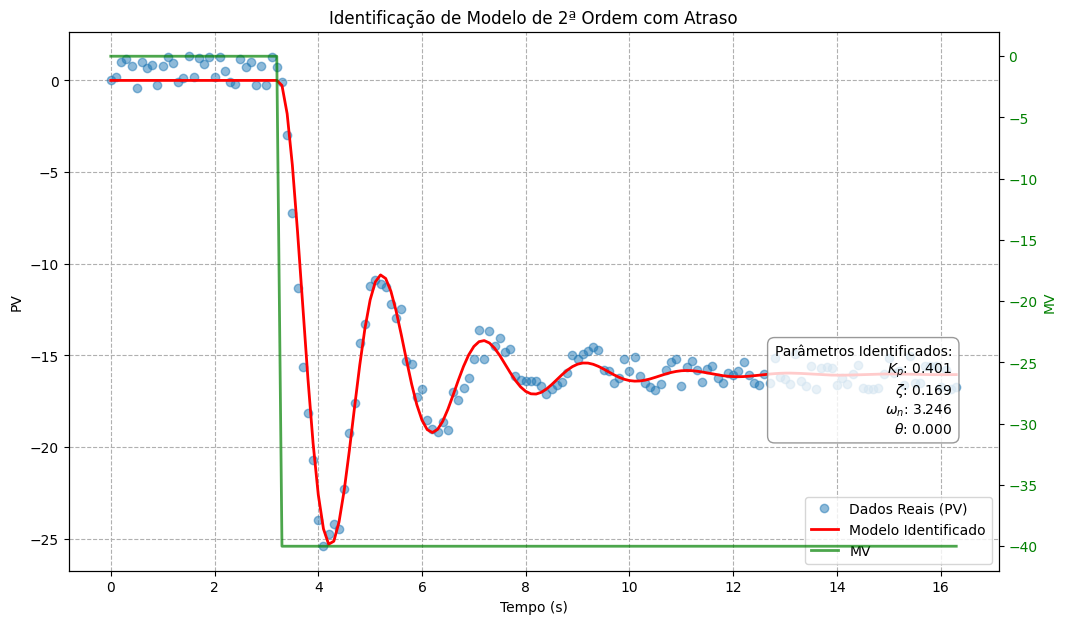

In [26]:
t_fit = t_sim - t_sim[0]

# --- 3. Identificação do Modelo ---
initial_Kp = (PV_sim[-1] - PV_sim[0]) / (MV_sim[-1] - MV_sim[0])
print(f"\nChute inicial para Kp: {initial_Kp:.3f}")
if model_type == 'sobreamortecido':
    initial_guess = [initial_Kp, 30, 10, 2]
    bounds = ([0.0, 0, 0, 0], [30, np.inf, np.inf, np.inf])
    
    def process_model_fit(t, Kp, tau1, tau2, theta):
        return Second_order_Process_Model(t, Kp, tau1, tau2, theta, model_type, MV_sim)

elif model_type == 'zeta_wn':
    initial_guess = [initial_Kp, 0.5, 0.2, 2]
    bounds = ([-np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])

    def process_model_fit(t, Kp, zeta, wn, theta):
        return Second_order_Process_Model(t, Kp, zeta, wn, theta, model_type, MV_sim)

MV_diff = MV_sim[-1] - MV_sim[0]
if MV_diff == 0:
    print("Erro: A entrada (MV) não é um degrau.")
else:
    PV_adjusted = PV_sim - PV_sim[0]
    
    print("\nIniciando a otimização (curve_fit)...")
    try:
        # AQUI É A MUDANÇA: 't_fit' é usado no lugar de 't_sim'
        popt, pcov = curve_fit(
            process_model_fit,
            t_fit,
            PV_adjusted,
            p0=initial_guess,
            bounds=bounds
        )
        
        # --- 4. Validação e Visualização dos Resultados ---
        fig, ax1 = plt.subplots(figsize=(12, 7))
        ax2 = ax1.twinx()

        # AQUI É A MUDANÇA: 't_fit' é usado para calcular o fit, mas o resultado
        # é plotado contra o 't_sim' original
        PV_fit = process_model_fit(t_fit, *popt)

        # --- salvar CSV se for simulação ---
        if data_choice == 'sim':
            resultados = pd.DataFrame({
                "Tempo": t_sim,
                "MV": MV_sim,
                "PV_sim": PV_sim,
                "PV_modelo": PV_fit + PV_sim[0]
            })
            resultados.to_csv("resultados_simulacao.csv", sep=';', index=False)
            print("\nDados simulados e modelo identificado exportados para 'resultados_simulacao.csv'.")

        
        if model_type == 'sobreamortecido':
            Kp_fit, tau1_fit, tau2_fit, theta_fit = popt
            params_text = (f"Parâmetros Identificados:\n"
                           f"$K_p$: {Kp_fit:.3f}\n"
                           f"$\\tau_1$: {tau1_fit:.3f}\n"
                           f"$\\tau_2$: {tau2_fit:.3f}\n"
                           f"$\\theta$: {theta_fit:.3f}")
        else:
            Kp_fit, zeta_fit, wn_fit, theta_fit = popt
            params_text = (f"Parâmetros Identificados:\n"
                           f"$K_p$: {Kp_fit:.3f}\n"
                           f"$\\zeta$: {zeta_fit:.3f}\n"
                           f"$\\omega_n$: {wn_fit:.3f}\n"
                           f"$\\theta$: {theta_fit:.3f}")

        print("\n" + params_text)

        # Plotando PV no eixo esquerdo (ax1)
        ax1.plot(t_sim, PV_sim, 'o', color='#1f77b4', label='Dados Reais (PV)', alpha=0.5)
        ax1.plot(t_sim, PV_fit + PV_sim[0], 'r-', label='Modelo Identificado', linewidth=2)
        ax1.set_xlabel('Tempo (s)')
        ax1.set_ylabel('PV')
        ax1.grid(True, linestyle='--')
        
        # Plotando MV no eixo direito (ax2)
        ax2.plot(t_sim, MV_sim, 'g-', label='MV', linewidth=2, alpha=0.7)
        ax2.set_ylabel('MV', color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        ax2.grid(False)
        
        plt.title('Identificação de Modelo de 2ª Ordem com Atraso')
        
        ax1.text(0.95, 0.25, params_text,
                 transform=ax1.transAxes,
                 fontsize=10,
                 horizontalalignment='right',
                 verticalalignment='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray'))
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
        
        plt.show()

    except RuntimeError as e:
        print(f"Erro na otimização: {e}")
        print("A otimização pode não ter convergido. Tente ajustar o 'initial_guess'.")